### Deep Ensamble MDN Toy Example ###

"We use the same network architecture: 1-hidden layer neural network with ReLU nonlinearity (Nair and Hinton, 2010), containing 50 hidden units for smaller datasets and 100 hidden units for the larger protein and Year Prediction MSD datasets"

"We trained for 40 epochs; we refer to (Herna ́ndez-Lobato and Adams, 2015) for further details about the datasets and the experimental protocol. We used 5 networks in our ensemble. Our results are shown in Table 1, along with the PBP and MC-dropout results reported in their respective papers"

"On some datasets, we observe that our method is slightly worse in terms of RMSE. We believe that this might be caused due to the het- eroscedastic regression training criterion, which optimises for NLL instead of MSE as discussed in the toy example in Figure 3."

In [319]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [320]:
%autoreload 2

In [321]:
%matplotlib inline

In [322]:
import os
import copy
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from aml_dl.mdn.model.tf_ensemble_mdn_model import EnsambleMDN

from aml_dl.gp.simple_gp import GaussianProcess, kernel

from IPython import display
import time

In [323]:
from aml_robot.box2d.core.data_manager import DataManager

In [324]:
from aml_robot.box2d.push_world.config import config

In [325]:
from aml_io.convert_tools import string2image

## Configs

In [326]:
EXP_NAME = 'exp_ensemble'

check_point_dir   = os.environ['AML_DATA'] + '/aml_dl/mdn/tf_check_points/exp_ensemble_pushing/'
summary_dir = os.environ['AML_DATA'] + '/aml_dl/mdn/summaries/exp_ensemble_pushing/'
data_dir = os.environ['AML_DATA'] + '/aml_dl/box2d_push_data'

if not os.path.exists(check_point_dir):
    os.makedirs(check_point_dir)

if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

adam_params = {
    'type': 'adam',
    'params': {'learning_rate' : 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'use_locking': False}
}

network_params = {
    'n_ensembles': 5,
    'dim_input': 5, 
    'dim_output': 4,
    'n_hidden': [20,20,10],#[20,20,10],
    'k_mixtures': 1,
    'write_summary': False,
    'load_saved_model': False,
    'model_dir': check_point_dir + '/inv/',
    'model_name':'ensemble_model_inv_10_kernels.ckpt',
    'optimiser': adam_params,
    'summary_dir':summary_dir+'/inv/',
    'device': '/cpu:0',
}

In [327]:
data_xs = [None]*3
data_actions = [None]*3
data_ys = [None]*3

In [328]:
for i in range(0,3):
    data_manager = DataManager()
    data_manager = data_manager.from_file(filename='data_train_%d.pkl'%(i,),data_folder=config['data_folder_path'])
    
    data_x_t = np.array(data_manager.pack_data_x(['state_start'],range(0,500)))
    data_x_t_1 = np.array(data_manager.pack_data_x(['state_end'],range(0,500)))
    data_action = np.array(data_manager.pack_data_y(range(0,500)))
    
    data_xs[i] = np.concatenate([data_x_t,data_action], axis=1)
    data_actions[i] = data_action
    data_ys[i] = data_x_t_1

In [329]:
data_x = np.concatenate([data_xs[0],data_xs[1],data_xs[2]], axis=0)

In [330]:
len(data_y)

1500

In [331]:
data_manager = DataManager()
data_manager = data_manager.from_file(filename='data_test_3.pkl',data_folder=config['data_folder_path'])
    
data_x_t = np.array(data_manager.pack_data_x(['state_start'],range(0,500)))
data_x_t_1 = np.array(data_manager.pack_data_x(['state_end'],range(0,500)))
data_action = np.array(data_manager.pack_data_y(range(0,500)))
    
xs = np.concatenate([data_x_t,data_action], axis=1)
acs = data_action
ys = data_x_t_1

In [332]:
data_test_x = xs

In [333]:
data_test_y = ys

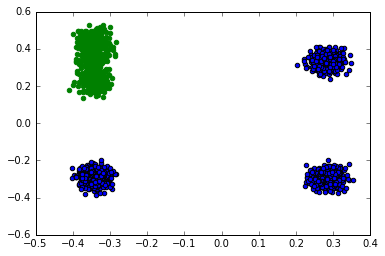

In [334]:
plt.scatter(data_test_x[:,0],data_test_y[:,1],color='g')
plt.scatter(data_x[:,0],data_x[:,1])

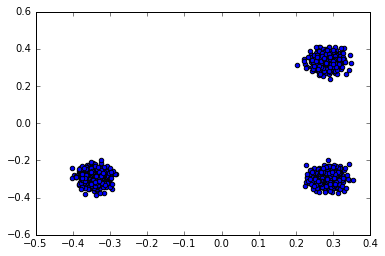

In [335]:
plt.scatter(data_x[:,0],data_x[:,1])

In [336]:
img=string2image(state_start['image_rgb'])

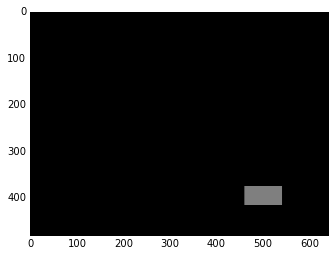

In [337]:
plt.imshow(img)

In [338]:
state_start.keys()

['position', 'image_rgb', 'linear_velocity', 'angle', 'angular_velocity']

In [339]:
action

array([[  0.        ,   0.        ,  10.        ,   0.46402743]])

In [340]:
# print data_manager.get_sample(i,'state_start')

In [341]:
tf.set_random_seed(42)
sess = tf.InteractiveSession()

In [342]:
ensamble_mdn = EnsambleMDN(network_params,sess)

In [343]:
ensamble_mdn._init_model()

## Prepare data

In [344]:
iterations = 40

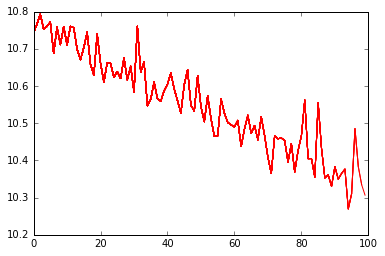

In [353]:
mean_loss = []
for i in range(100):
    loss = ensamble_mdn.train(data_x, data_y, sess, iterations)
    #fig, mloss = test_and_plot(i, loss)
    mean_loss.append(np.mean(loss))
    #ax2 = fig.add_subplot(414)
    plt.plot(mean_loss, 'r-')
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)
    
#     ax = fig2.add_subplot(212)
#     ax.plot(np.arange(100, iterations,1), loss[0, 100:], 'r-')

In [356]:
ensamble_mdn.save_model()

Model saved in file: /Users/ermanoarruda/Projects/ros_ws/aml_data/aml_dl/mdn/tf_check_points/exp_ensemble_pushing//inv/ensemble_model_inv_10_kernels.ckpt


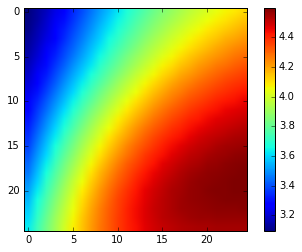

In [355]:
unc_map = np.zeros((25,25))
mean_map = np.zeros((25,25))

test_x_coord = np.linspace(-0.5, 0.5, 30)
test_y_coord = np.linspace(0.5, -0.5, 30)
test_action = np.linspace(0, 2*np.pi, 25)

for i in range(25):
    for j in range(25):
        for k in range(25):
            mean_out, var_out = ensamble_mdn.forward(sess, [[test_x_coord[j],test_y_coord[i],0,0,test_action[k]]])
            
            unc_map[i,j] += np.mean(var_out[0])
            
plt.imshow(unc_map/25)
plt.colorbar()

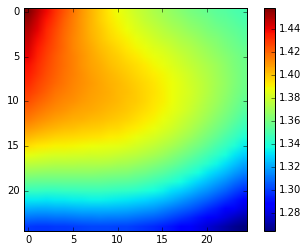

In [303]:
unc_map = np.zeros((25,25))
mean_map = np.zeros((25,25))

test_x_coord = np.linspace(-0.4, 0.4, 25)
test_y_coord = np.linspace(0.4, -0.4, 25)
test_action = np.linspace(0, 2*np.pi, 25)

for j in range(25):
    for i in range(25):
        for k in range(25):
            mean_out, var_out = ensamble_mdn.forward(sess, [[test_x_coord[i],test_y_coord[j],0,0,test_action[k]]])
            
            unc_map[i,j] += np.mean(var_out[0])
            
plt.imshow(unc_map/25)
plt.colorbar()

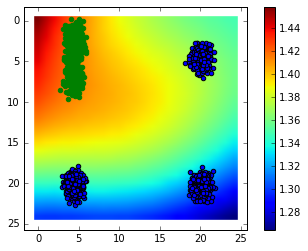

In [317]:
plt.imshow(unc_map/25)
plt.colorbar()
plt.scatter(data_x[:,0]*25+13,-data_x[:,1]*25+13)
plt.scatter(data_test_x[:,0]*25 + 13,-data_test_y[:,1]*25 + 13,color='g')

### Uncertainty after 600 iterations

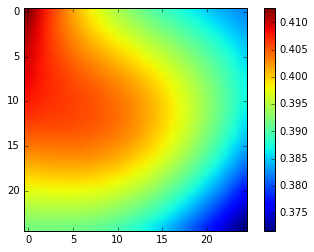

In [180]:
unc_map = np.zeros((25,25))
mean_map = np.zeros((25,25))

test_x_coord = np.linspace(-0.4, 0.4, 25)
test_y_coord = np.linspace(0.4, -0.4, 25)
test_action = np.linspace(0, 2*np.pi, 25)

pred_xs = np.zeros((25,25))
pred_ys = np.zeros((25,25))

for j in range(25):
    for i in range(25):
        for k in range(25):
            mean_out, var_out = ensamble_mdn.forward(sess, [[test_x_coord[i],test_y_coord[j],0,0,test_action[k]]])
            
            unc_map[i,j] += np.mean(var_out[0])
            
plt.imshow(unc_map/25)
plt.colorbar()

## Uncertainty after 400 iterations

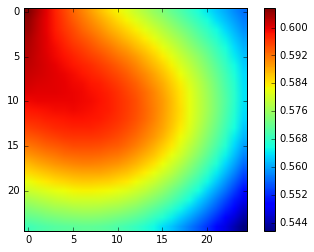

In [178]:
unc_map = np.zeros((25,25))
mean_map = np.zeros((25,25))

test_x_coord = np.linspace(-0.4, 0.4, 25)
test_y_coord = np.linspace(0.4, -0.4, 25)
test_action = np.linspace(0, 2*np.pi, 25)

pred_xs = np.zeros((25,25))
pred_ys = np.zeros((25,25))

for j in range(25):
    for i in range(25):
        for k in range(25):
            mean_out, var_out = ensamble_mdn.forward(sess, [[test_x_coord[i],test_y_coord[j],0,0,test_action[k]]])
            
            unc_map[i,j] += np.mean(var_out[0])
            
plt.imshow(unc_map/25)
plt.colorbar()

## Uncertainty after 200 iterations

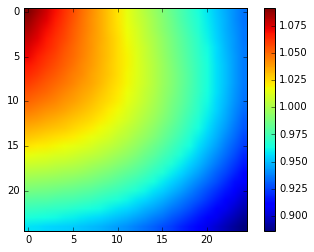

In [176]:
unc_map = np.zeros((25,25))
mean_map = np.zeros((25,25))

test_x_coord = np.linspace(-0.4, 0.4, 25)
test_y_coord = np.linspace(0.4, -0.4, 25)
test_action = np.linspace(0, 2*np.pi, 25)

pred_xs = np.zeros((25,25))
pred_ys = np.zeros((25,25))

for j in range(25):
    for i in range(25):
        for k in range(25):
            mean_out, var_out = ensamble_mdn.forward(sess, [[test_x_coord[i],test_y_coord[j],0,0,test_action[k]]])
            
            unc_map[i,j] += np.mean(var_out[0])
            
plt.imshow(unc_map/25)
plt.colorbar()

In [ ]:
## 50 Interval (training for longer)

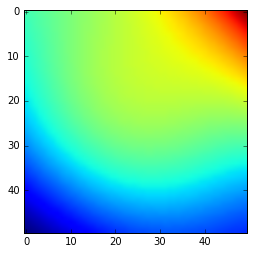

In [167]:
unc_map = np.zeros((50,50))
mean_map = np.zeros((50,50))

test_x_coord = np.linspace(-0.5, 0.5, 50)
test_y_coord = np.linspace(-0.5, 0.5, 50)
test_action = np.linspace(0, 2*np.pi, 50)

for i in range(50):
    for j in range(50):
        for k in range(50):
            mean_out, var_out = ensamble_mdn.forward(sess, [[test_x_coord[i],test_x_coord[j],0,0,test_action[k]]])
            unc_map[i,j] += np.mean(var_out[0])
            
plt.imshow(unc_map/50)

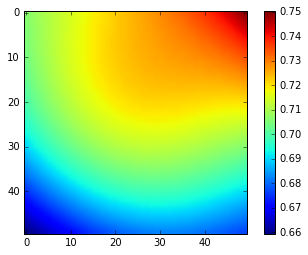

In [169]:
unc_map = np.zeros((50,50))
mean_map = np.zeros((50,50))

test_x_coord = np.linspace(-0.4, 0.4, 50)
test_y_coord = np.linspace(-0.4, 0.4, 50)
test_action = np.linspace(0, 2*np.pi, 50)

for i in range(50):
    for j in range(50):
        for k in range(50):
            mean_out, var_out = ensamble_mdn.forward(sess, [[test_x_coord[i],test_y_coord[j],0,0,test_action[k]]])
            unc_map[i,j] += np.mean(var_out[0])
            
plt.imshow(unc_map/50)
plt.colorbar()

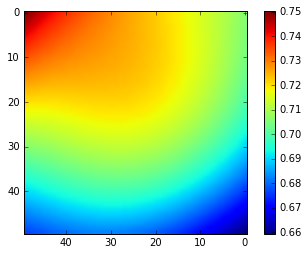

In [171]:
plt.imshow(unc_map/50)
plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

In [150]:
unc_map = np.zeros((50,50))
mean_map = np.zeros((50,50))

In [151]:
test_x_coord = np.linspace(-0.5, 0.5, 50)
test_y_coord = np.linspace(-0.5, 0.5, 50)

In [152]:
test_action = np.linspace(0, 2*np.pi, 50)

In [153]:
for i in range(50):
    for j in range(50):
        for k in range(50):
            mean_out, var_out = ensamble_mdn.forward(sess, [[test_x_coord[i],test_x_coord[j],0,0,test_action[k]]])
            unc_map[i,j] += np.mean(var_out[0])

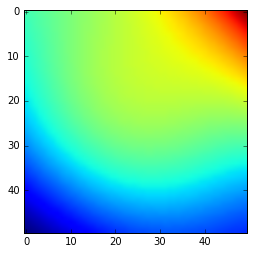

In [154]:
plt.imshow(unc_map/50)

## 100 Interval 

In [155]:
unc_map = np.zeros((100,100))
mean_map = np.zeros((100,100))

In [156]:
test_x_coord = np.linspace(-0.5, 0.5, 100)
test_y_coord = np.linspace(-0.5, 0.5, 100)

In [157]:
test_action = np.linspace(0, 2*np.pi, 100)

In [158]:
for i in range(100):
    for j in range(100):
        for k in range(100):
            mean_out, var_out = ensamble_mdn.forward(sess, [[test_x_coord[i],test_x_coord[j],0,0,test_action[k]]])
            unc_map[i,j] += np.mean(var_out[0])

### Training for longer

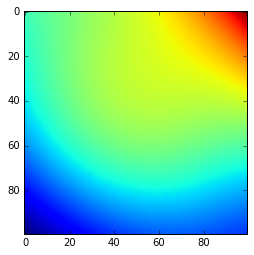

In [159]:
plt.imshow(unc_map/100)

## Initial training

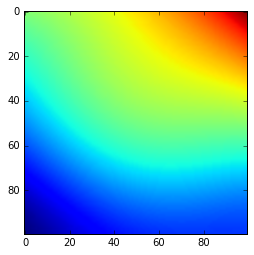

In [148]:
plt.imshow(unc_map/100)

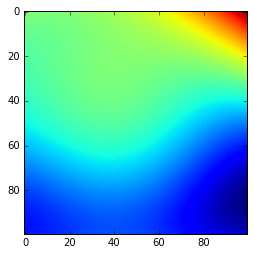

In [142]:
plt.imshow(unc_map/100)

In [275]:
mean_out, var_out = ensamble_mdn.forward(sess, data_test_x)
std = np.sqrt(np.mean(var_out,axis=1))
std_test = np.sum(np.sqrt(np.mean(var_out,axis=1)))
print std_test

9385.93896974


In [302]:
mean_out_train, var_out_train = ensamble_mdn.forward(sess, data_x[0:501])
std_train = np.sqrt(np.mean(var_out,axis=1))
std_test = np.sum(np.sqrt(np.mean(var_out_train,axis=1)))
print std_test

9177.7007321


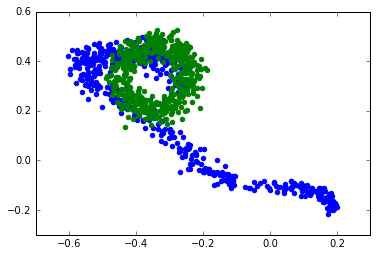

In [262]:
plt.scatter(mean_out[:,0],mean_out[:,1],color='b')
plt.scatter(data_test_y[:,0],data_test_y[:,1],color='g')

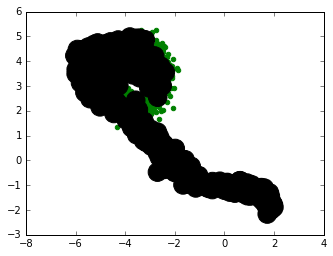

In [298]:
from matplotlib.patches import Circle

# Get an example image
import matplotlib.cbook as cbook
# image_file = cbook.get_sample_data('grace_hopper.png')
# img = plt.imread(image_file)

# Make some example data
x = np.random.rand(5)*0.4
y = np.random.rand(5)*0.4

# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1)
ax.set_aspect('equal')


# Now, loop through coord arrays, and create a circle at each x,y pair
for xx,yy,s in zip(mean_out[:,0]*10,mean_out[:,1]*10,std):
    circ = Circle((xx,yy),s/50,color='k')
    ax.add_patch(circ)
    
# Show the image
ax.scatter(mean_out[:,0]*10,mean_out[:,1]*10,color='m')
ax.scatter(data_test_y[:,0]*10,data_test_y[:,1]*10,color='g')



# Show the image
plt.show()

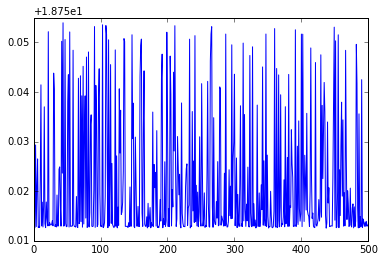

In [301]:
plt.plot(std)

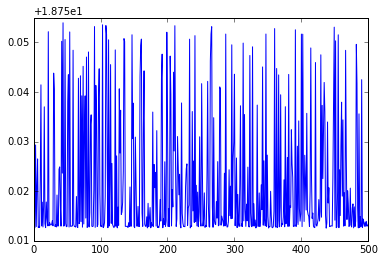

In [288]:
plt.plot(std_train)

## Test

In [27]:
x_test = gdx_values#np.linspace(0, 12, num_data_points)
y_test = gdy_values #fun_h(x_test, 0.0)

In [28]:
out_mus = ensamble_mdn.run_op(sess, 'mus', np.expand_dims(x_test,axis=1))
out_sigma = ensamble_mdn.run_op(sess, 'sigmas', np.expand_dims(x_test,axis=1))
out_pis = ensamble_mdn.run_op(sess, 'pis', np.expand_dims(x_test,axis=1))

In [29]:
# out_mus = np.reshape(out_mus,(-1,1))
# out_sigma = np.reshape(out_sigma,(-1,1))
# out_pis = np.reshape(out_pis,(-1,1))

In [30]:
# print np.reshape(out_mus[0],(-1,1))
# print out_sigma.shape
# print out_pis.shape